In [7]:
from keras.src.activations import threshold
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [8]:
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

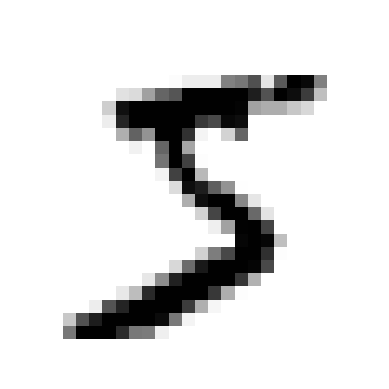

In [9]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')


some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [10]:
y[0]

'5'

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 훈련

In [14]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [16]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

## 교차 검증을 사용한 정확도 측정
cross_val_score()함수로 폴드가 3개인 k-폴드 교차 검증을 사용해 SGD모델을 평가해보겠다.<br>
K-폴드 교차 검증은 훈련 세트를 k개(여기서 3개)의 폴드로 나누고, 평가를 위해 매번 다른 폴드를 떼어놓고 모델을 k번 훈련한다.

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.94475, 0.9673 , 0.96465])

**정확도**가 95% 이상이다.<br>
모든 이미지를 가장 많이 등장하는 클래스로 분류하는 더미 분류기를 만들겠다.(여기서는 '5'아님으로 분류한다)

In [18]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [19]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

**정확도**가 90% 이상이다.<br>
이미지의 10%만 '5'이기 때문에 맞출 확률이 90%이다.


정확도를 분류기의 성능 측정 지표로 선호하지 않는다.**불균형한 데이터셋**을 다룰 때 (즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그렇다.<br>
**confusion matrix**을 조사하면 더 좋은 성능평가가 가능하다.


## 오차 행렬
오차 행렬은 모든 A/B쌍에 대해 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다. <br>
예를 들어 분류기가 숫자 8의 이미지를 0으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬에서 8번 행 0번 열을 보면 된다.

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() 함수는 K-폴드 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다.

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[54144,   435],
       [ 1856,  3565]])

오차 행령의 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타낸다.<br>
이 행렬의 첫 번째 행은 '5아님'**(negative class)**에 대한 것으로, 54,144개를 '5 아님'으로 정확하게 분류했고**(true negative라고 한다.)** 나머지 435개는 '5'라고 잘못 분류했다 **(false positive라고 부른다)**<br>
두 번째 행은 '5' 이미지 **(positive class)**에 대한 것으로, 1856개를 '5 아님'으로 잘못 분류했고 **(false negative라고 한다.)** 나머지 3,565개를 정확히 '5'라고 분류했다 **(true positive라고 한다)**

$$precision = \frac{TP}{TP + FP} \qquad (TP = true\;positive,\quad FP = false\;positive)$$
<br>
precision은 **recall**이라는 지표와 함께 사용한다. 재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 **sensitivity** 또는 **true positive rate(TPR)** 이라고도 한다.
<br>
$$recall = \frac{TP}{FP + FN} \qquad (FN = false\;negative)$$

![confusion martix 쉽게 이해하기](./hands%20on%20.png)


In [23]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.89125
0.6576277439586792


recall과 precision을 **F1 score**라고 하는 하나의 숫자로 만들면 편리하다.<br>
F1 score는 **harmonic mean**이다.<br>

$$
F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7568198705020699

precision을 올리면 recall이 줄고 그 반대도 마찬가지다. 이를 **precision/recall 트레이드오프라고 한다**

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([4257.4848007])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [41]:
threshold = 5000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True, False, False, ...,  True, False, False])

이 결과는 임계값을 높이면 recall이 줄어든다는 것을 보여준다.<br>
실제로 이미지가 5이고 임계값이 0일 때는 분류기가 이를 감지했지만 임계값을 3,000으로 높이면 이를 놓치게 된다.

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [37]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

임계값이 5000일때 precision, recall을 그려보자

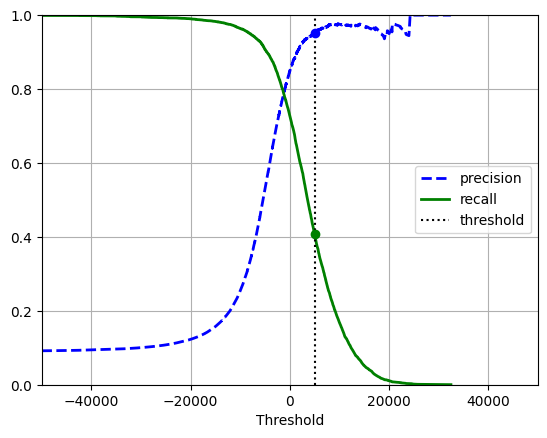

In [44]:
plt.plot(thresholds, precision[:-1], "b--", label="precision", linewidth=2)
plt.plot(thresholds, recall[:-1], "g-", label="recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # 첫 번째 index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

이 임계값(5000)에서는 precisiond은 90%이고 recall은 약 50%이다. <br>
좋은 정밀도, 재현율을 선택하는 방법은 재현율에 대한 정밀도 곡선을 그리는것이다.

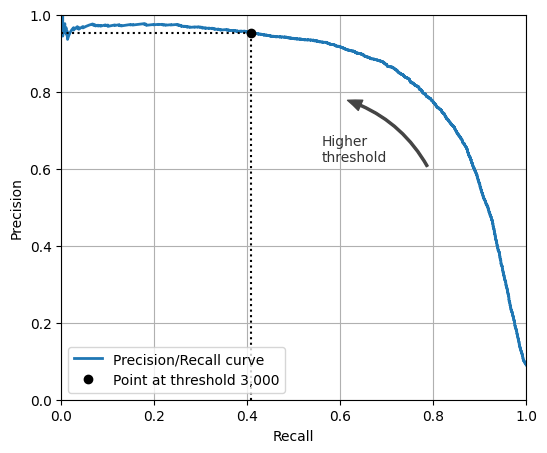

In [46]:
import matplotlib.patches as patches  # 추가 코드 – 구부러진 화살표를 그리기 위해서
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

precision을 90%로 만드는것을 목표로 해보자

In [47]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(1512.4928247737216)

In [48]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [49]:
precision_score(y_train_5, y_train_pred_90)

0.9001300390117035

## ROC 곡선
**receiver operating characteristic(ROC)** 곡선도 이진 분류에서 널리 사용되는 도구이다.<br>
precision/recall 곡선과 매우 유사하지만, **false positivie rate(FPR)** 에 대한 **true positivie rate(TPR)** 의 곡선이다.<br>
FPR은 양성으로 잘못 분류된 음성 샘플의 비율이다. 이는 1 - **true engative rate(TNR)**이다. TNR을 **specificity**라고도 한다. <br>
ROC 곡선은 **sensitivity**에 대한 **1-specificity** 그래프 이다.

In [50]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

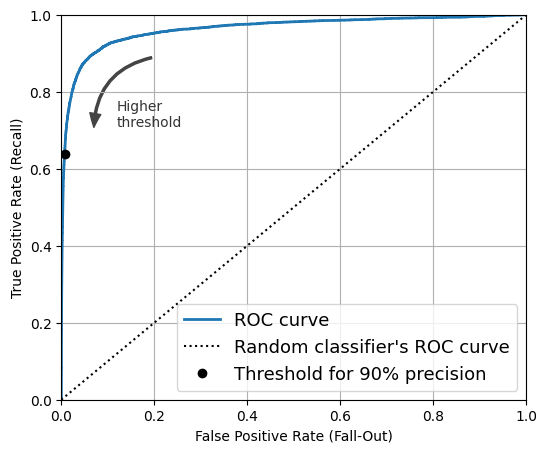

In [52]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.figure(figsize=(6, 5))  # 추가 코드
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# 추가 코드 – 그림 3–7을 그리고 저장합니다
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

**area under the curve(AUC)** 을 측정해 분류기들을 비교할 수 있다.<br>
완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다.

In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.963539455148015)

ROC가 PR(precision/recall) 곡선과 비슷해서 어떤 것을 사용해야 할지 궁금할 수 있다.<br>
일반적으로 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할때 PR 곡선을 사용하고 그렇지 않다면 ROC를 사용한다.

In [54]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [55]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [56]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

이 모델은 첫 번째 이미지를 89%로 양성이라고 예측하고, 98% 확률로 음성이라 예측한다.

In [60]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

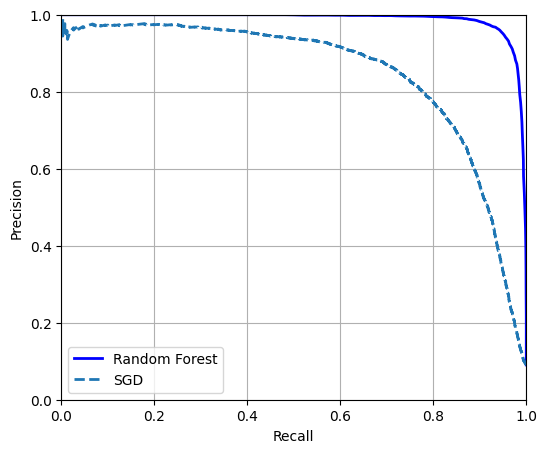

In [62]:
plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# 추가 코드 – 그림 3–8을 그리고 저장합니다
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()


랜덤 포레스트가 SGD보다 훨씬 좋다. PR 곡선이 오른쪽 위 모서리에 훨씬 가까워 AUC가 더 높기 때문이다.